In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab_Notebooks/perturbation_metric_test
!pip install anndata 
!pip install git+https://github.com/theislab/scgen.git
!pip install matplotlib
!pip install scanpy


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks/perturbation_metric_test
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pyparsing/core.py", line 4891, in parseImpl
    return super().parseImpl(instring, loc, doActions)
  File "/usr/local/lib/python3.10/dist-packag

In [3]:
import anndata
import scanpy as sc
import scgen
import pandas as pd  
import numpy as np
import torch
import torch.nn.functional as F

font = {'family' : 'Arial',
        'size'   : 14}
train = sc.read("./data/PapalexiSatija2021_eccite_RNA.h5ad")
train.layers['counts'] = train.X.copy()
sc.pp.log1p(train)
sc.pp.highly_variable_genes(train, n_top_genes=10, subset=True)
train.X = train.layers['counts']

from scvi import settings

def log_zinb_positive(
    x: torch.Tensor, mu: torch.Tensor, theta: torch.Tensor, pi: torch.Tensor, eps=1e-8
):
    """Log likelihood (scalar) of a minibatch according to a zinb model.
    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant
    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(
            1, theta.size(0)
        )  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)

    res = mul_case_zero + mul_case_non_zero

    return res

from typing import Union
import jax.numpy as jnp

def log_nb_positive(
    x: Union[torch.Tensor, jnp.ndarray],
    mu: Union[torch.Tensor, jnp.ndarray],
    theta: Union[torch.Tensor, jnp.ndarray],
    eps: float = 1e-8,
    log_fn: callable = torch.log,
    lgamma_fn: callable = torch.lgamma,
):
    """Log likelihood (scalar) of a minibatch according to a nb model.
    Parameters
    ----------
    x
        data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    log_fn
        log function
    lgamma_fn
        log gamma function
    """
    log = log_fn
    lgamma = lgamma_fn
    log_theta_mu_eps = log(theta + mu + eps)
    res = (
        theta * (log(theta + eps) - log_theta_mu_eps)
        + x * (log(mu + eps) - log_theta_mu_eps)
        + lgamma(x + theta)
        - lgamma(theta)
        - lgamma(x + 1)
    )

    return res

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [4]:
from statsmodels.discrete.count_model import (ZeroInflatedNegativeBinomialP, ZeroInflatedPoisson,
                                              ZeroInflatedGeneralizedPoisson)

import matplotlib.pyplot as plt
import statsmodels.api as sm 
from joblib import Parallel,delayed
import torch
import torch.nn.functional as F
def data_prep(adata,conditions=None,sample_ctrl=False):
    """
    param
    -----------
    adata
    return_mean: bool variable True if we want to compute mean of sampled data per cell to
    find statistic between mean of data from sample1 and sample2
    output: the sampled data from sample1 and sample2 of type array
    """
    control = adata[adata.obs["perturbation"] == conditions["x"]]
    stim = adata[adata.obs["perturbation"] == conditions["y"]]
    
    #fix the number of rows of sampled data as the minimum number of rows between sample1,sample2
    n=np.minimum(control.shape[0],stim.shape[0])
    
    x,_ = sample_obs(control,n)
    y,_ = sample_obs(stim,n)
        
    x=x.toarray()
    y=y.toarray() 
    
    return x,y

def dist_based(x,y):
    """
    transpose the data so that we can compute static between genes (columns)
    """
    m=np.minimum(x.shape[0],y.shape[0])
    x=x.T[:,:m]#delete .toarray()
    y=y.T[:,:m]
    return x,y

def sample_obs(adata,size_n):
    """
    params 
    -------------
    sample for all control and stim pairs 
    size_n:the number of rows we will consider in comparison
    output x,y in sparse matrix form
    which is sample1 and sample2 drawn from two specified codition
    """

    x = adata.X
    #print(x.shape)(16893, 6998)
    n_rows=x.shape[0]
    
    df = pd.DataFrame({'x':np.arange(n_rows)})
    #shuffle the data index
    x_sample1=df['x'].sample(frac=1, replace=False).values[:size_n]
    x_sample2=df['x'].sample(frac=1, replace=False).values[:size_n]
    
    return x[x_sample1,:], x[x_sample2,:]

import random

def subset(alist, idxs):
    '''
        use idxs to subset alist
        alist: list
        idxs: list
    '''
    sub_list = []
    for idx in idxs:
        sub_list.append(alist[idx])

    return sub_list

def split_list(alist, group_num=3, shuffle=True, retain_left=False):
    '''
        split data into 3 subset and let each subset contains the len(alist)//group number of elements
        shuffle: whether shuffle the splitted data, default: True
        retain_left: if list alist is splited into the number of group_num subset and there is some element remain，
        whether take the remaining elements as a subset
    '''

    index = list(range(len(alist))) 

    
    if shuffle: 
        random.shuffle(index) 
    
    elem_num = len(alist) // group_num 
    sub_lists = {}
    
   
    for idx in range(group_num):
        start, end = idx*elem_num, (idx+1)*elem_num
        sub_lists[str(idx)] = subset(alist, index[start:end])
    
  
    if retain_left and group_num * elem_num != len(index): 
        sub_lists[str(idx+1)] = subset(alist, index[end:])
    
    return sub_lists



def sample_control_control(adata,size_n):
    """
    the sampling for ctrl and ctrl
    split the data into three samples
    shuffle the three samples
    return two data set have maximum between-sample distance
    
    """
    x = adata.X
    n_rows=x.shape[0]
    index_dict=split_list(range(n_rows))# in form {0: [1,2,3],1:[3,44,2...],3:[]}
    sample1=x[index_dict['0'],:size_n].toarray()
    sample2=x[index_dict['1'],:size_n].toarray()
    sample3=x[index_dict['2'],:size_n].toarray() 
    
    pairs={}
    pairs[0]=(sample1,sample2)
    pairs[1]=(sample1,sample3)
    pairs[2]=(sample2,sample3)
    return pairs 

def process_item_alpha(i,x):
    # plt.hist(x[i],bins=30)
    # plt.yscale('log')
    # plt.show()
    
    # print(all(elem == 0 for elem in x[i]))
    print("gene",i)

    if all(elem == 0 for elem in x[i]):
        return None 

    else:
        one=np.ones_like(x[i])
        # model=sm.NegativeBinomialP(x[i],one).fit()
        model=ZeroInflatedNegativeBinomialP(x[i],one).fit() 
        if model.params[2]>0:
            # print(model.summary())
            return model.params[2]
        else:
            return None 
    
def process_item_const(i,x):
    # plt.hist(x[i],bins=30)
    # plt.yscale('log')
    # plt.show()
    
    # print(all(elem == 0 for elem in x[i]))
    print("gene",i)

    if all(elem == 0 for elem in x[i]):
        return None 

    else:
        one=np.ones_like(x[i])
        # model=sm.NegativeBinomialP(x[i],one).fit()
        model=ZeroInflatedNegativeBinomialP(x[i],one).fit() 
        if model.params[2]>0:
        # print(model.summary())
            return model.params[1]
        else:
            return None 

def process_per_batch(x,num_from,num_to):
    x=x[num_from:num_to,:]

    alpha=Parallel(n_jobs=-1,backend="multiprocessing")(
        delayed(process_item_alpha)(i,x)for i in range(x.shape[0])
    )

    const=Parallel(n_jobs=-1,backend="multiprocessing")(
        delayed(process_item_const)(i,x)for i in range(x.shape[0])
    ) 
    return alpha,const    


In [5]:
def test_get_data(zinb,train,metric_str):
    """
    fn: the function to get datasets after sampling before we fit the gene in sample1 and sample2
    
    """
    list_stim=list(train.obs['perturbation'].unique())
    list_stim.remove('control')
    conditions={"x":"control","y":"stim"}
    difference=[]
    if_stim=['stim']*len(list_stim)
    # sample1 is always sampled from control and sample2 is sampled from 99 different stim 
    #use prep_data to sample respectively 
     
    for stim in list_stim:
        conditions["y"]=str(stim)
        # print(conditions)
        out=zinb(train,conditions,str(stim))
        print("data:",out)
        difference.append(out)
    
    #lastly,for (ctrl,ctrl) where we apply a different sampling method, get three points 
    conditions["y"]="control"
    control = train[train.obs["perturbation"] == conditions["x"]]
    print(conditions)
    pairs=sample_control_control(control,control.shape[0])
     
    for i in range(3):
        (x,y)=pairs[i]
        out=zinb(adata=train,conditions=conditions,stim_str='control'+str(i),sample_ctrl=True,ctrl1=x,ctrl2=y)
        print(" data for (contrl, control):",out)
        difference.append(out)

    zero=['control']*3
    if_stim=if_stim + zero
    metric=[metric_str]*len(if_stim)
        
    return difference,if_stim,metric  

def compute_log_zinb(x,const_x,alpha_x):
    mu=np.exp(const_x)
    theta=1/alpha_x
    # p=1/(1+theta)*mu
    p=mu*theta/(1+theta)
    nan=0
    if 1-p<=0 or p<=0:
      most_frequent=0
      nan+=1
    else:
      logit=np.log((1-p)/p)
      x_val=log_zinb_positive(torch.tensor(x),torch.tensor(mu),torch.tensor(theta),torch.tensor(logit))
      # x_val=log_nb_positive(torch.tensor(x),torch.tensor(mu),torch.tensor(theta))
      most_frequent=torch.mode(x_val).values.item()
    return most_frequent,nan 

def zinb_fit_ctrl(adata, conditions,stim_str,sample_ctrl=False,ctrl1=None,ctrl2=None):
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,conditions)
        
    x,y=dist_based(x,y)
    alpha_x, const_x =process_per_batch(x,0,99)

    out=0
    count=0
    for i in range(x.shape[0]):
        if all(elem == 0 for elem in x[i]):
            continue
        if all(elem == 0 for elem in y[i]):
            continue 
        else:
          NoneType = type(None)
          if isinstance(const_x[i], NoneType) or isinstance(alpha_x[i], NoneType):
              continue 
          else:
              count+=1
              output,nan=compute_log_zinb(y[i],const_x[i],alpha_x[i])
              out+=output
              count-=nan
    
    if count==0:
      count=1# to avoid divison by zero     
            
    return out/count 

differece0,if_stim0,metric0=test_get_data(zinb_fit_ctrl,train,'zinb')

genegene  01

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.283309
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25Optimization terminated successfully.

         Current function value: 0.273154
gene         Iterations: 23 
         Function evaluations: 25
4         Gradient evaluations: 25

gene 6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.308716

         Current function value: 0.124776         Iterations: 23

         Function evaluations: 25
         Gradient evaluations: 25
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27gene 
5gene 
7
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.328769         Current function value: 0.034670

         Iterations: 24         Iterations: 24

         Function evaluations: 26         Functi

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.423419
         Iterations: 35gene
         Function evaluations: 37 
6
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/

Optimization terminated successfully.
         Current function value: 0.396020
         Iterations: 23
         Function evaluations: 26

         Gradient evaluations: 26gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.110823
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.479918gene
         Iterations: 35
          Function evaluations: 37
         Gradient evaluations: 37
4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.423419
         Iterations: 35         Gradient evaluations: 37
         Function evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.396020
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0009688458133799335
genegene  10

genegene 2 3

gene 4
Optimization terminated successfully.
         Current function value: 0.411517
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
6
         Current function value: 0.494160
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.094073gene
          Iterations: 19
5         Function evaluations: 24

         Gradient evaluations: 24
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.502429
         Iterations: 34

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1gene
 2
genegene  43

Optimization terminated successfully.         Current function value: 0.494160

         Current function value: 0.411517
         Iterations: 22
         Function evaluations: 25         Iterations: 35
         Gradient evaluations: 25

         Function evaluations: 37gene
 6
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.094073
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
geneOptimization terminated successfully. 
7
         Current function value: 0.502429
         Iterations: 34gene
 8
         Function evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0008673433839021527
genegene  10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.150050

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3
         Current function value: 0.327700
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.454566
         Iterations: 22

         Iterations: 35         Function evaluations: 24

         Function evaluations: 38
         Gradient evaluations: 38
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  76



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.124054


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 22
         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Iterations: 1         Current function value: nan

         Function evaluations: 112         Iterations: 1

         Function evaluations: 112         Gradient evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 1 
0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.150050
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.327700Warning: Desired error not necessarily achieved due to precision loss.

         Iterations: 35         Current function value: nan
         Function evaluations: 37

         Iterations: 1         Gradient evaluations: 37

         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 112 
4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.334059
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.454566
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully.
         Current function value: 0.124054
         Iterations: 22
         Function evaluations: 25
          Gradient evaluations: 25
gene7
 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local

         Current function value: nanWarning: Desired error not necessarily achieved due to precision loss.
         Iterations: 1
         Current function value: nan
         Function evaluations: 112
         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
data: -0.0003585745929740369
genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.205616
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
Optimization terminated successfully.         Gradient evaluations: 112

         Current function value: 0.228001

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 23gene
          Function evaluations: 264

         Gradient evaluations: 26
gene 5
Optimization terminated successfully.
         Current function value: 0.310060
         Iterations: 25
Optimization terminated successfully.         Function evaluations: 27

         Gradient evaluations: 27
         Current function value: 0.351537
gene         Iterations: 21
          Function evaluations: 23
         Gradient evaluations: 236



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.054859
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.135773
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.205616
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 4 
3
Optimization terminated successfully.
         Current function value: 0.310060
         Iterations: 25
Optimization terminated successfully.         Function evaluations: 27

         Current function value: 0.228001         Gradient evaluations: 27

         Iterations: 23gene
          Function evaluations: 265

         Gradient evaluations: 26
gene 6
Optimization terminated successfully.
         Current function value: 0.351537
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


geneOptimization terminated successfully.
         Current function value: 0.054859
         Iterations: 20
 7
gene 8
         Function evaluations: 25
         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.135773
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
data: -0.0001609255185381168
gene 0gene
 gene 2
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Iterations: 1

         Function evaluations: 112         Iterations: 1

         Gradient evaluations: 112
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.379705
         Iterations: 24
Optimization terminated successfully.         Function evaluations: 27

         Current function value: 0.240425
         Gradient evaluations: 27         Iterations: 24

         Function evaluations: 26
         Gradient evaluations: 26gene
 5
gene 6
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.173359
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
         Current function value: 0.548245
         Iterations: 19
gene         Function evaluations: 21 
7         Gradient evaluations: 21



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.228503


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nanOptimization terminated successfully.

         Iterations: 1         Current function value: 0.240425

         Function evaluations: 112         Iterations: 24

         Gradient evaluations: 112         Function evaluations: 26

         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4
gene 6
Optimization terminated successfully.
         Current function value: 0.173359Optimization terminated successfully.
         Current function value: 0.379705
         Iterations: 24
         Function evaluations: 27
         Iterations: 24

         Gradient evaluations: 27         Function evaluations: 27

gene         Gradient evaluations: 27
 5gene
 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.548245

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Iterations: 19

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -




         Function evaluations: 21         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 8
Optimization terminated successfully.
         Current function value: 0.228503
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0005959135305602103
genegene 0 1

gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: 0.471966
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.149985
         Iterations: 13


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 19

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 19
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.873310
         Iterations: 34


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.105981gene
          Iterations: 26
9         Function evaluations: 29

         Gradient evaluations: 29
gene gene0 
1gene
 2
gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/pyt

         Current function value: 0.471966
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.149985
         Iterations: 13
         Function evaluations: 19
         Gradient evaluations: 19
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.873310
         Iterations: 34

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.         Current function value: nan

         Current function value: 0.105981
         Iterations: 1
         Function evaluations: 112         Iterations: 26
         Gradient evaluations: 112

         Function evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 29gene 
9
data: -0.005149347347469302
gene 0gene
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.124489

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 27
         Gradient evaluations: 27
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
Optimization terminated successfully.         Function evaluations: 112

         Current function value: 0.354687         Gradient evaluations: 112

         Iterations: 21
         Function evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 23gene
 4gene
 5

         Current function value: 0.356440
         Current function value: 0.543449         Iterations: 35

         Iterations: 35         Function evaluations: 37

         Function evaluations: 37         Gradient evaluations: 37

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene 76

gene 8
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.084035
         Current function value: 0.212844         Iterations: 22

         Iterations: 20         Function evaluations: 26
         Function evaluations: 23
         Gradient evaluations: 26

         Gradient evaluations: 23
gene 9
genegene 1 
0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.
         Current function value: 0.124489
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: nan3

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.354687
         Iterations: 21

         Current function value: 0.356440         Gradient evaluations: 23

         Iterations: 35gene
          Function evaluations: 375

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.         Current function value: 0.543449
         Iterations: 35

         Function evaluations: 37
         Current function value: 0.084035         Gradient evaluations: 37

         Iterations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 26gene
          Gradient evaluations: 26
7
genegene  9
8
Optimization terminated successfully.
         Current function value: 0.212844
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
data: -0.0005322918483064617
genegene  10

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.103992
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28Optimization terminated successfully.
         Current function value: 0.392544

         Iterations: 21
gene         Function evaluations: 23 
4         Gradient evaluations: 23

gene 6
Optimization terminated successfully.
         Current function value: 0.152908
         Iterations: 22Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.365837

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
         Function evaluations

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Gradient evaluations: 25gene
 5gene
 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.529887

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discre

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.103992
         Iterations: 25
         Function evaluations: 28
Optimization terminated successfully.
         Gradient evaluations: 28
         Current function value: 0.392544
gene         Iterations: 21 4

         Function evaluations: 23
         Gradient evaluations: 23
gene 6
Optimization terminated successfully.
         Current function value: 0.152908
         Iterations: 22

         Gradient evaluations: 25
         Current function value: 0.365837
         Iterations: 35
gene          Function evaluations: 387

gene          Gradient evaluations: 388



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow en

         Current function value: 0.529887
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discre

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0006303777524408361
genegene 1 
0gene 2

Optimization terminated successfully.
         Current function value: 0.056868Optimization terminated successfully.

         Current function value: 0.108410
         Iterations: 26         Iterations: 20

         Function evaluations: 30         Function evaluations: 26

         Gradient evaluations: 26
         Gradient evaluations: 30
gene 3gene 4

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.373966

         Iterations: 22
         Current function value: 0.263662
         Function evaluations: 25         Iterations: 23

         Function evaluations: 25         Gradient evaluations: 25

         Gradient evaluations: 25
genegene 5 6

Optimization terminated successfully.
         Current function value: 0.105947
         Current function value: 0.587326         Iterations: 23

         Function evaluations: 26         Iterations: 35

         Gradient evaluations:

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 
gene 8
9
Optimization terminated successfully.
         Current function value: 0.172698
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
gene gene0 
1
gene 2
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.108410
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30

gene         Current function value: 0.056868
         Iterations: 20
          Function evaluations: 26
3
         Gradient evaluations: 26
gene 4
Optimization terminated successfully.
         Current function value: 0.373966
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25Optimization terminated successfully.

         Current function value: 0.263662gene
          Iterations: 23
6         Function evaluations: 25

         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.105

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.172698
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
data: -0.0006427488227321495
genegene  0
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.179830
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 4
         Current function value: 0.419459
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.273759gene
          Iterations: 276
         Function evaluations: 29

         Gradient evaluations: 29
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.         Current function value: 0.156555

         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 7
         Current function value: 0.498254
         Iterations: 35
Optimization terminated successfully.         Function evaluations: 37

         Current function value: 0.036906         Gradient evaluations: 37

         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 25 
         Gradient evaluations: 258

gene 9
Optimization terminated successfully.
         Current function value: 0.074851
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
genegene  0
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.179830
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 4
         Current function value: 0.419459
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.273759
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.gene
 5         Current function value: 0.156555

         Iterations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 24
         Gradient evaluations: 24
gene 7
         Current function value: 0.498254
         Iterations: 35Optimization terminated successfully.

         Current function value: 0.036906         Function evaluations: 37

         Gradient evaluations: 37         Iterations: 20

         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 25
 8
gene 9
Optimization terminated successfully.
         Current function value: 0.074851
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
data: -0.0004008506166854886
genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.092850
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.229710

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Function evaluations: 24

         Gradient evaluations: 24         Iterations: 1

         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Gradient evaluations: 112 
4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.349053
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26

         Current function value: 0.585069
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
7         Current function value: 0.092850

gene         Iterations: 25 
         Function evaluations: 28
8
         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.092850
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.229710


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 24         Current function value: nan

         Gradient evaluations: 24         Iterations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 112gene
          Gradient evaluations: 1124



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.349053
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
6         Current function value: 0.585069

         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.092850

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0008963118551037041
genegene  10

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.112828

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



gene 3
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.251187
         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan

         Iterations: 1
         Function evaluations: 112         Gradient evaluations: 112gene 
4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.390669
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 5Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.116154
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
gene 8
         Current function value: 0.462487
         Iterations: 35
         Function evaluations: 37Optimization terminated successfully.
         Gradient evaluations: 37

         Current function value: 0.209017

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Iterations: 229

         Function evaluations: 26
         Gradient evaluations: 26
genegene  0
1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.112828

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 3
Optimization terminated successfully.
         Current function value: 0.251187
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Iterations: 22

         Iterations: 1         Function evaluations: 25

         Function evaluations: 112
         Gradient evaluations: 25
         Gradient evaluations: 112
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


6
         Current function value: 0.462487
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Current function value: 0.1161548

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
gene 9
Optimization terminated successfully.
         Current function value: 0.209017
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
data: -0.0004145868858055716
gene 0gene 
1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.193568

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Gradient evaluations: 27
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.379598

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 33
         Function evaluations: 151
         Gradient evaluations: 151


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.656676

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 1
gene         Function evaluations: 112
          Gradient evaluations: 1127

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.193568


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 24
         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.379598
         Iterations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -




gene         Current function value: nan 5



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 33
         Function evaluations: 151
         Gradient evaluations: 151


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.656676

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00201093927656378
genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.108385

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Function evaluations: 27
         Gradient evaluations: 27
gene 2
gene 3
         Current function value: 0.357662
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Current function value: 0.2770965

         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
gene 6
         Current function value: 0.528218
         Iterations: 35Optimization terminated successfully.
         Function evaluations: 38

         Current function value: 0.139530         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 18gene
          Function evaluations: 237
gene 
8         Gradient evaluations: 23

gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.108385
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 35         Iterations: 1

         Function evaluations: 112         Function evaluations: 38
         Gradient evaluations: 112

         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 5
 4
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.277096

         Current function value: 0.528218         Iterations: 22

         Iterations: 35         Function evaluations: 24

         Function evaluations: 38

         Gradient evaluations: 24         Gradient evaluations: 38
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  67

gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.139530

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0005640085451886989
gene 0gene 
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.
         Current function value: 0.136400
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/stat

gene 3
Optimization terminated successfully.
         Current function value: 0.378926
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
Optimization terminated successfully.         Gradient evaluations: 112

         Current function value: 0.368306
         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 23gene
         Gradient evaluations: 23 
5
gene 6
         Current function value: 0.510705Optimization terminated successfully.
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37

         Current function value: 0.201657
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  8
7
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.029144         Current function value: 0.184574

         Iterations: 16         Iterations: 19

         Function evaluations: 22         Function evaluations: 21

         Gradient evaluations: 21
         Gradient evaluations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 9
genegene 0
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.136400

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 1gene 
3
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.378926
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 5
Optimization terminated successfully.
         Current function value: 0.368306
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 6
         Current function value: 0.510705
         Iterations: 35Optimization terminated successfully.

         Current function value: 0.201657         Function evaluations: 37

         Gradient evaluations: 37         Iterations: 22

         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 25
 7gene
 8
Optimization terminated successfully.
         Current function value: 0.184574
Optimization terminated successfully.         Iterations: 19

         Function evaluations: 21
         Gradient evaluations: 21
         Current function value: 0.029144


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 16gene
          Function evaluations: 229
         Gradient evaluations: 22

data: -0.0006903011032151815
gene gene0
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.189335
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
geneOptimization terminated successfully. 
4         Current function value: 0.210041

         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
gene 6
Optimization terminated successfully.
         Current function value: 0.390680
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 5Optimization terminated successfully.

         Current function value: 0.141955
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22
gene 7
Optimization terminated successfully.gene 
         Current function value: 0.3229528

         Iterations: 21
         Function

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.164174

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning:

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.292541

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 24
         Function evaluations: 26 
         Gradient evaluations: 264

gene 5
Optimization terminated successfully.
         Current function value: 0.379844
         Iterations: 21
         Function evaluations: 23Optimization terminated successfully.
         Gradient evaluations: 23

         Current function value: 0.508079
gene         Iterations: 34 6

         Function evaluations: 42
         Gradient evaluations: 42
gene 7
Optimization terminated successfully.
         Current function value: 0.157237
         Iterations: 22Optimization terminated successfully.

         Function evaluations: 25         Current function value: 0.033019

         Gradient evaluations: 25         Iterations: 17

gene         Function evaluations: 22 
8         Gradient evaluations: 22

gene 9
Optimization terminated successfully.
         Current function value: 0.163085
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
geneg

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.164174
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encoun

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.292541
         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

         Gradient evaluations: 26         Iterations: 1
         Function evaluations: 112
gene
         Gradient evaluations: 112
 4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.379844
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
geneOptimization terminated successfully.
          Current function value: 0.5080796

         Iterations: 34
         Function evaluations: 42
         Gradient evaluations: 42
gene 7Optimization terminated successfully.

         Current function value: 0.157237
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
geneOptimization terminated successfully.
 8         Current function value: 0.033019

         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22
gene 9
Optimization terminated successfully.
         Current function value: 0.163085
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
data: -0.0003885384260987242
genegene  0
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.
         Current function value: 0.099533
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 2
gene 3
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.205818


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 21
         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



4         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.153110
         Iterations: 23
         Function evaluations: 26gene
 5         Gradient evaluations: 26

gene 6
Optimization terminated successfully.
         Current function value: 0.183339Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.484987

         Iterations: 35         Function evaluations: 40
         Gradient evaluations: 40


         Iterations: 24
         Function evaluations: 27         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
genegene  98



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.099533

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 27
         Gradient evaluations: 27
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.205818

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 21         Current function value: nan

         Function evaluations: 24         Iterations: 1

         Gradient evaluations: 24         Function evaluations: 112

         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5
Optimization terminated successfully.
         Current function value: 0.153110
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene         Current function value: 0.484987 
6         Iterations: 35

         Function evaluations: 40
         Gradient evaluations: 40


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.183339


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0004293757683626609
gene gene 10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.
         Current function value: 0.114933
         Iterations: 24
         Function evaluations: 29
         Gradient evaluations: 29
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.269461
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 4
         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.288259

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 22
gene          Function evaluations: 26
5
         Gradient evaluations: 26
gene 6
Optimization terminated successfully.
         Current function value: 0.429746
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 7
geneOptimization terminated successfully.
          Current function value: 0.1050578
         Iterations: 24

         Function evaluations: 27
         Gradient evaluations: 27
gene 9
Optimization terminated successfully.
         Current function value: 0.247110
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
genegene  1
0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.
         Current function value: 0.114933
         Iterations: 24
         Function evaluations: 29
         Gradient evaluations: 29
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan         Current function value: 0.269461

         Iterations: 1         Iterations: 22

         Function evaluations: 112         Function evaluations: 24

         Gradient evaluations: 24
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 5
 4
Optimization terminated successfully.
         Current function value: 0.429746
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.gene
 6         Current function value: 0.288259

         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.105057
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 9Optimization terminated successfully.

         Current function value: 0.247110
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
data: -0.00023915193605716922
genegene  01

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.126250
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
gene          Current function value: 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6

         Current function value: 0.361495         Current function value: 0.192902

         Iterations: 25
         Iterations: 35         Function evaluations: 28

         Function evaluations: 37         Gradient evaluations: 28

         Gradient evaluations: 37
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7
gene gene8 
5
Optimization terminated successfully.
         Current function value: 0.088327
         Iterations: 24
         Function evaluations: 28Optimization terminated successfully.
         Gradient evaluations: 28
         Current function value: 0.450983

         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23gene 
9
gene gene 01

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.126250
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
         Current function value: 0.293424
          Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.


         Current function value: 0.192902         Current function value: 0.361495
         Iterations: 35         Iterations: 25

         Function evaluations: 37         Function evaluations: 28

         Gradient evaluations: 37         Gradient evaluations: 28



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 7
5gene
 8
Optimization terminated successfully.
         Current function value: 0.450983
         Iterations: 21Optimization terminated successfully.
         Function evaluations: 23

         Gradient evaluations: 23         Current function value: 0.088327
         Iterations: 24

gene 9
         Function evaluations: 28
         Gradient evaluations: 28
data: -0.00033244423176862864
genegene  1
0gene
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.196848
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
gene         Current function value: 0.351048 4
         Iterations: 21

         Function evaluations: 23
         Gradient evaluations: 23
gene 6
Optimization terminated successfully.
         Current function value: 0.286791
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
gene 5Optimization terminated successful

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7
genegene 8
 9
Optimization terminated successfully.
         Current function value: 0.134136
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
genegene 0
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.196848
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 4Optimization terminated successfully.

         Current function value: 0.351048
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 6
Optimization terminated successfully.
         Current function value: 0.286791
         Iterations: 20
         Function evaluations: 23Optimization terminated successfully.
         Gradient evaluations: 23

gene         Current function value: 0.139399 5

         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
geneOptimization terminated successfully. 7

gene         Current function 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


geneOptimization terminated successfully. 
         Current function value: 0.1341369

         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
data: -0.00042412092443555593
genegene  01

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.204699
         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Gradient evaluations: 26
gene 3
Optimization terminated successfully.
         Current function value: 0.392083
         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 25
 4
         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.445721
         Iterations: 35
         Function evaluations: 37
Optimization terminated successfully.         Gradient evaluations: 37

         Current function value: 0.116807

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 23
gene         Function evaluations: 26
         Gradient evaluations: 26
 gene7 5

Optimization terminated successfully.
         Current function value: 0.061531Warning: Maximum number of iterations has been exceeded.

         Iterations: 18         Current function value: 0.449846

         Iterations: 35         Function evaluations: 22
         Function evaluations: 45

         Gradient evaluations: 22         Gradient evaluations: 45



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8gene 9



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10
gene
 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.204699
         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

Optimization terminated successfully.
         Current function value: 0.392083
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.445721

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: nangene
         Iterations: 1 
         Function evaluations: 112
5         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.449846
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully.
          Current function value: 0.116807
8         Iterations: 23



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.061531
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.011878261262523893
genegene  10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.068071


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.273095

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nangene
          Iterations: 14

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

         Iterations: 24         Current function value: 0.479054

         Function evaluations: 27         Iterations: 35

         Gradient evaluations: 27         Function evaluations: 37

         Gradient evaluations: 37
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

Optimization terminated successfully.
         Current function value: 0.140719
         Iterations: 17
         Function evaluations: 23
         Gradient evaluations: 23
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.068071
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3
Optimization terminated successfully.
         Current function value: 0.273095
         Iterations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


4         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.271642
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.479054


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.140719

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan

         Function evaluations: 23         Iterations: 1

         Gradient evaluations: 23         Function evaluations: 112

gene         Gradient evaluations: 112 
9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0003698242842347099
genegene  10

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.281928
         Iterations: 24Optimization terminated successfully.

         Function evaluations: 28
         Current function value: 0.117736         Gradient evaluations: 28

         Iterations: 22
         Function evaluations: 25
gene          Gradient evaluations: 254

gene 6
         Current function value: 0.380899
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.135531
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.633396
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 37
         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.117736
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 4Optimization terminated successfully.

         Current function value: 0.281928
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 6
Optimization terminated successfully.         Current function value: 0.380899

         Current function value: 0.135531         Iterations: 35

         Iterations: 24         Function evaluations: 38

         Function evaluations: 27         Gradient evaluations: 38

         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene5 7



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.633396


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0008124104049784364
gene 0gene
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.181040

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 23
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112Optimization terminated successfully.

         Gradient evaluations: 112
         Current function value: 0.233947

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 22gene 4

         Function evaluations: 25
         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
gene 6
         Current function value: 0.460229
         Iterations: 35Optimization terminated successfully.

         Function evaluations: 37         Current function value: 0.090176
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28

         Gradient evaluations: 37
gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.041973
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.188934
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.181040


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.233947

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 22
         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 25
         Current function value: nan
         Iterations: 1 4

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.394467
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
gene 6
         Current function value: 0.460229
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.090176
         Iterations: 25
         Function evaluations: 28Optimization terminated successfully.

         Gradient evaluations: 28         Current function value: 0.041973

gene         Iterations: 20 
8         Function evaluations: 25

         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.188934
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
data: -0.0002851328807277501
gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.244843

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 3
         Current function value: 0.308714
         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 46


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


4
         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.395725

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 38
         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.625677
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.220375
         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 25
         Gradient evaluations: 25
         Current function value: nan9
         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dpara

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  0
1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.244843

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.308714
         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 46


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.395725

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.625677
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 41

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Warning: Desired error not necessarily achieved due to precision loss.8

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: 0.220375 7

gene 9         Iterations: 22

         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.008092095860774862
gene 0gene
 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.160296
         Iterations: 25
         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 3
Optimization terminated successfully.
         Current function value: 0.150656
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112Optimization terminated successfully.
         Current function value: 0.264295

         Iterations: 25
         Function evaluations: 27         Gradient evaluations: 112

         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene5 
6
Optimization terminated successfully.
         Current function value: 0.232356
         Iterations: 22Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 24
         Current function value: 0.388626         Gradient evaluations: 24

         Iterations: 35
gene          Function evaluations: 45
7         Gradient evaluations: 45

gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.085798
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
genegene  0
1
gene 2
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.160296
         Iterations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.150656
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.264295         Current function value: nan

         Iterations: 25         Iterations: 1

         Function evaluations: 27         Function evaluations: 112

         Gradient evaluations: 112         Gradient evaluations: 27



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5gene 
6
Optimization terminated successfully.
         Current function value: 0.232356

         Function evaluations: 24         Current function value: 0.388626

         Gradient evaluations: 24         Iterations: 35

         Function evaluations: 45gene
 7         Gradient evaluations: 45

gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.085798
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
data: -0.0007348192050358193
genegene  01

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.137327
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene Warning: Maximum number of iterations has been exceeded.4

         Current function value: 0.362410
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.340106
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
gene 5
Optimization terminated successfully.
         Current function value: 0.347769
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.gene
         Current function value: 0.109772 8
         Iterations: 21

         Function evaluations: 25
         Gradient evaluations: 25
gene 7
geneOptimization terminated successfully. 9
         Current function value: 0.131296
         Iterations: 20

         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.029123
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
genegene  10

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.1373

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.340106
         Current function value: 0.109772
         Iterations: 21         Iterations: 25

         Function evaluations: 27
         Gradient evaluations: 27
         Function evaluations: 25
         Gradient evaluations: 25
gene gene5 
7
gene 8
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.347769

         Iterations: 23
         Function evaluations: 26         Current function value: 0.131296
         Gradient evaluations: 26

         Iterations: 20gene
         Function evaluations: 25 
9         Gradient evaluations: 25

Optimization terminated successfully.
         Current function value: 0.029123
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
data: -0.0002366754611102806
genegene 
0 1
gene 2
gene 3
Optimization terminated successfully.
         C

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.451589

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.717460


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 32

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 34Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan         Gradient evaluations: 34

         Iterations: 1gene 8

         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.080169
         Iterations: 20
         Function evaluations: 24Optimization terminated successfully.

         Current function value: 0.269487         Gradient evaluations: 24

         Iterations: 19gene
         Function evaluations: 22
          Gradient evaluations: 224

gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.451589

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 23
         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.717460


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 32

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Function evaluations: 34

         Iterations: 1         Gradient evaluations: 34
         Function evaluations: 112

gene         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflo

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0017797436035493774
gene gene0
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.057071
         Iterations: 20
         Function evaluations: 26
         Gradient evaluations: 26
gene 4

         Current function value: 0.470203         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Current function value: 0.257858
         Iterations: 226

         Function evaluations: 26
         Gradient evaluations: 26
gene 5
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.567433         Current function value: 0.127972
         Iterations: 23
         Function evaluations: 26

         Gradient evaluations: 26
         Iterations: 35
         Function evaluations: 37gene 
         Gradient evaluations: 37
7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene8
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01
gene
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.057071
         Iterations: 20
         Function evaluations: 26
         Gradient evaluations: 26
gene 4
         Current function value: 0.470203
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.
6         Current function value: 0.257858
         Iterations: 22

         Function evaluations: 26
         Gradient evaluations: 26
gene 5
Optimization terminated successfully.
         Current function value: 0.127972Warning: Maximum number of iterations has been exceeded.

         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
         Current function value: 0.567433
gene         Iterations: 35 
7         Function evaluations: 37

gene          Gradient evaluations: 378



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0007284393872396322
genegene  10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.170141
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.360056
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully.
         Current function value: 0.314395
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
 5gene 6

Optimization terminated successfully.
         Current function value: 0.178099
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23

         Current function value: 0.545806
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
8         Current function value: 0.023248

         Iterations: 15
         Function evaluations: 21
         Gradient evaluations: 21
gene 9
Optimization terminated successfully.
         Current function value: 0.239899
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.170141
         Iterations: 26
         Function evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.360056

         Iterations: 23
         Current function value: nan         Function evaluations: 26
         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5gene
 4
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.314395         Current function value: 0.545806

         Iterations: 35         Iterations: 24

         Function evaluations: 38
         Gradient evaluations: 38
         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 27
 6
gene 7
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.178099

         Iterations: 20         Current function value: 0.023248

         Iterations: 15
         Function evaluations: 23         Function evaluations: 21

         Gradient evaluations: 23         Gradient evaluations: 21

genegene  89

Optimization terminated successfully.
         Current function value: 0.239899
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
data: -0.0005120856664386034
gene gene 0
1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.190462
         Iterations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 3
Optimization terminated successfully.
         Current function value: 0.259795
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6         Current function value: 0.369469

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5Optimization terminated successfully.

         Current function value: 0.187884
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.353247
         Iterations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 28
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.190462
         Iterations: 25         Function evaluations: 28

         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


3
Optimization terminated successfully.
         Current function value: 0.259795
         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.369469
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.1878845

         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.353247
         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 28
         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0002554216218413785
genegene  10

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.195811
         Iterations: 24         Current function value: 0.325768

         Function evaluations: 27         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37         Gradient evaluations: 27

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4gene
 6
Optimization terminated successfully.
         Current function value: 0.177256
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 7
gene Warning: Maximum number of iterations has been exceeded.8

         Current function value: 0.386411


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.540338
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 01

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.195811
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 4Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.325768
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.386411
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5Optimization terminated successfully.

         Current function value: 0.177256


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 24
         Gradient evaluations: 24
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.540338
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0006630785581364762
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.069622
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
Optimization terminated successfully.
         Current function value: 0.255546
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.gene
 6         Current function value: 0.310117

         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
gene 5
Optimization terminated successfully.
         Current function value: 0.089130
         Iterations: 24
         Function evaluations: 27Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 27         Current function value: 0.503593
         Iterations: 35

gene          Function evaluations: 377

gene         Gradient evaluations: 37 
8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01

gene 2
gene Optimization terminated successfully.3

         Current function value: 0.069622
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
Optimization terminated successfully.
         Current function value: 0.255546
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 6
Optimization terminated successfully.
         Current function value: 0.310117
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
geneOptimization terminated successfully. 
         Current function value: 0.0891305

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
gene 8Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.503593


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 37
         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0003701826229416838
genegene  0
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.124315
         Iterations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Function evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 2
Optimization terminated successfully.
         Current function value: 0.043263
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: nan         Current function value: 0.376670

         Iterations: 1         Iterations: 22

         Function evaluations: 112         Function evaluations: 25

         Gradient evaluations: 112         Gradient evaluations: 25

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4gene 
5
Optimization terminated successfully.
         Current function value: 0.424484Optimization terminated successfully.

         Iterations: 23         Current function value: 0.505728

         Iterations: 25
         Function evaluations: 25         Function evaluations: 27
         Gradient evaluations: 27
         Gradient evaluations: 25


gene 6
gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.131517
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.129204
         Iterations: 13
         Function evaluations: 19
         Gradient evaluations: 19
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.124315

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 25
         Function evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 2
Optimization terminated successfully.
         Current function value: 0.043263
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.376670 
4         Iterations: 22

         Function evaluations: 25
         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.424484
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene
          Current function value: 0.5057286

         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.131517


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 28
gene 8
Optimization terminated successfully.
         Current function value: 0.129204
         Iterations: 13
         Function evaluations: 19
         Gradient evaluations: 19


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0005388700939571814
genegene  01

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.132710
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

Optimization terminated successfully.
         Current function value: 0.323031
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.         Current function value: nan
         Iterations: 1
         Current function value: 0.384680

         Iterations: 23         Function evaluations: 112

         Gradient evaluations: 112         Function evaluations: 26

         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene5
 6
         Current function value: 0.605853
         Iterations: 35Optimization terminated successfully.

         Current function value: 0.096993
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene         Function evaluations: 41 7

         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  w

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.132710


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 24
         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



gene 3
Optimization terminated successfully.
         Current function value: 0.323031


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 25
         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 28
         Current function value: nan
gene         Iterations: 1 
4         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.384680
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 5
Optimization terminated successfully.
         Current function value: 0.096993
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.605853

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 41

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 41

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene9 


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0007551256575425213
genegene 0
 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.121049

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 17

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 3
Optimization terminated successfully.
         Current function value: 0.307958
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
Optimization terminated successfully.         Function evaluations: 112

         Current function value: 0.322043         Gradient evaluations: 112

         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Function evaluations: 286
         Gradient evaluations: 28

gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.133788
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26Optimization terminated successfully.

         Current function value: 0.504270gene
 7         Iterations: 23

         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/

Optimization terminated successfully.
         Current function value: 0.220596
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.121049

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 17
         Function evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 23
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.307958

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Function evaluations: 26

         Gradient evaluations: 26
         Iterations: 1
gene         Function evaluations: 112 
4         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6Optimization terminated successfully.

         Current function value: 0.322043
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
gene 5Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.133788
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.504270
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
gene 8
Optimization terminated successfully.
         Current function value: 0.220596
         Iterations: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 23
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0003919326624478951
genegene  0
1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.110904


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 3
Optimization terminated successfully.
         Current function value: 0.325107

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Gradient evaluations: 22

         Iterations: 1
gene          Function evaluations: 1124
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.281461
         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Current function value: 0.486915

         Gradient evaluations: 112
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 39

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 39 
7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 8
Optimization terminated successfully.
         Current function value: 0.036197
         Iterations: 20
Optimization terminated successfully.         Function evaluations: 25
         Gradient evaluations: 25

         Current function value: 0.115905
gene         Iterations: 22 
9         Function evaluations: 26

         Gradient evaluations: 26
genegene 1 
0gene
 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.110904
         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.325107


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan4

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
6         Current function value: 0.281461

         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow en

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 5
         Current function value: 0.486915
         Iterations: 35
         Function evaluations: 39

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Current function value: nan8

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.115905
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 9
Optimization terminated successfully.
         Current function value: 0.036197
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
data: -0.0004226961015980635
genegene  0
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.251108
Optimization terminated successfully.         Iterations: 22

         Current function value: 0.160657         Function evaluations: 25

         Iterations: 25         Gradient evaluations: 25
         Function evaluations: 28

         Gradient evaluations: 28gene
 4
gene 6
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.131940         Current function value: 0.303036

         Iterations: 21         Iterations: 13

         Function e

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
genegene  10

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.160657
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28Optimization terminated successfully.

         Current function value: 0.251108gene 
4         Iterations: 22

         Function evaluations: 25
         Gradient evaluations: 25
gene 6
Optimization terminated successfully.
         Current function value: 0.303036
         Iterations: 21Optimization terminated successfully.
         Function evaluations: 23

         Current function value: 0.131940         Gradient evaluations: 23

         Iterations: 13gene
          Function evaluations: 195

         Gradient evaluations: 19
gene 7
gene 8
         Current function value: 0.383457Optimization terminated successfully.

         Current function value: 0.159272
         Iterations: 23
         Iterations: 35
         Function evaluations: 25         Function evaluations: 39

        

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 9
data: -0.00029469917656873196
genegene  10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.062231


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 26
gene 2
gene 3
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.215593
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
gene 4
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.253598
Optimization terminated successfully.
         Current function value: 0.408429         Iterations: 24
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23

gene         Function evaluations: 27 6

         Gradient evaluations: 27
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.054915
         Iterations: 24
         Function evaluations: 29
         Gradient evaluations: 29
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  0
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.062231

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.         Current function value: nan

         Current function value: 0.215593         Iterations: 1

         Iterations: 20         Function evaluations: 112

         Function evaluations: 23         Gradient evaluations: 112

         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  45

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.408429

         Current function value: 0.253598         Iterations: 20

         Function evaluations: 23         Iterations: 24

         Gradient evaluations: 23         Function evaluations: 27

         Gradient evaluations: 27
genegene 6 
7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.054915

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 29
         Gradient evaluations: 29
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0001938377201554431
gene gene0
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.130857

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 27
         Gradient evaluations: 27
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.340686

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 28Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: nan

         Gradient evaluations: 28         Iterations: 1

         Function evaluations: 112gene
         Gradient evaluations: 112 4



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.190029
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
         Current function value: 0.531843 
         Iterations: 356

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.156443
         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.130180
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 1



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.130857

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.340686
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.190029
         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 26Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan         Gradient evaluations: 26
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  56

Optimization terminated successfully.

         Current function value: 0.531843
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 26gene
         Gradient evaluations: 26
 7gene 8



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Current function value: 0.130180
         Iterations: 16

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00039191615223899134
genegene 0
 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.130532


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 3
         Current function value: 0.260363
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 48
         Gradient evaluations: 48

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Function evaluations: 112
          Gradient evaluations: 1124



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.381169
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene
         Current function value: 0.167166 5

         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
gene 8
         Current function value: 0.552258
         Iterations: 35
Optimization terminated successfully.
         Function evaluations: 39
         Current function value: 0.114284         Gradient evaluations: 39

         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 27 9
         Gradient evaluations: 27



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.130532

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 23         Function evaluations: 26

         Gradient evaluations: 26
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.260363
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 48


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



Optimization terminated successfully.         Current function value: 0.381169
         Iterations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 24gene
         Gradient evaluations: 24
gene 
6 5
Optimization terminated successfully.
         Current function value: 0.167166
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
         Current function value: 0.552258 
         Iterations: 35
7         Function evaluations: 39


         Gradient evaluations: 39gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.114284
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning:

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0007223226057249121
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.107294

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 19

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 23
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.359623         Current function value: nan

         Iterations: 1         Iterations: 21

         Function evaluations: 112         Function evaluations: 24
         Gradient evaluations: 112
         Gradient evaluations: 24

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene4 
5
Optimization terminated successfully.
         Current function value: 0.254306
         Iterations: 20
         Function evaluations: 24Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.536521         Gradient evaluations: 24
         Iterations: 35

         Function evaluations: 37
gene         Gradient evaluations: 37
 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.149842
         Iterations: 23Optimization terminated successfully.

         Function evaluations: 26
         Gradient evaluations: 26         Current function value: 0.142289

gene         Iterations: 23
          Function evaluations: 27
         Gradient evaluations: 27
9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 0
gene 1
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.107294
         Iterations: 19


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.359623
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.254306

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Function evaluations: 24
         Current function value: nan         Gradient evaluations: 24

         Iterations: 1
gene         Function evaluations: 112 
5         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.         Current function value: 0.536521

         Current function value: 0.149842         Iterations: 35

         Iterations: 23         Function evaluations: 37
         Function evaluations: 26
         Gradient evaluations: 37

         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 8 7

gene 9
Optimization terminated successfully.
         Current function value: 0.142289
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.0004404202433458219
gene gene 10
gene
 2
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.133044

         Iterations: 23
         Current function value: 0.037017         Function evaluations: 26

         Iterations: 20         Gradient evaluations: 26

         Function evaluations: 25
gene         Gradient evaluations: 25 
3
gene 4
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.272083
         Iterations: 20
         Current function value: 0.264133

         Iterations: 23
         Function evaluations: 23         Function evaluations: 26

         Gradient evaluations: 23
         Gradient evaluations: 26
gene gene 65

Optimization terminated successfully.
         Current function value: 0.154420
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23Warning: Maximum number of iterations has been exceeded.

     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.107913
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
genegene  10

gene 2
Optimization terminated successfully.
         Current function value: 0.133044
         Iterations: 23Optimization terminated successfully.

         Function evaluations: 26         Current function value: 0.037017
         Gradient evaluations: 26

         Iterations: 20
gene          Function evaluations: 253
         Gradient evaluations: 25

gene 4
Optimization terminated successfully.
         Current function value: 0.272083
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23Optimization terminated successfully.

gene 6
         Current function value: 0.264133
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
geneOptimization terminated successfully.
         Current function value: 0.154420
       

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Function evaluations: 299

         Gradient evaluations: 29
data: -0.00036505036496237153
gene gene0 
1gene
 gene2 
3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.170793

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 27
         Gradient evaluations: 27
gene 4
Optimization terminated successfully.
         Current function value: 0.358768

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan
         Iterations: 1         Gradient evaluations: 26

         Function evaluations: 112
         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.235257
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
          Current function value: 0.5712067

         Iterations: 35gene
          Function evaluations: 448

         Gradient evaluations: 44


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.262640
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21
genegene  01

genegene 3 
2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.170793


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 27
gene 4
Optimization terminated successfully.
         Current function value: 0.358768


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

gene         Iterations: 1 
         Function evaluations: 1125

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.571206
         Iterations: 35
Optimization terminated successfully.         Function evaluations: 44
         Gradient evaluations: 44

         Current function value: 0.235257
         Iterations: 24
         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 27
genegene 8
 7
gene 9
Optimization terminated successfully.
         Current function value: 0.262640
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21
data: -0.0008334410264069448
genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.287221

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.381853

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Iterations: 234

         Function evaluations: 26
         Gradient evaluations: 26
gene 5
Optimization terminated successfully.
         Current function value: 0.423795
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
gene         Current function value: 0.523139 
6         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.173563


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



Optimization terminated successfully.
         Current function value: 0.172832
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  0
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.287221
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.         Current function value: nan
         Iterations: 1

         Current function value: 0.381853
         Iterations: 23
         Function evaluations: 26         Function evaluations: 112
         Gradient evaluations: 26

gene         Gradient evaluations: 112
 4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.423795
         Iterations: 23
         Function evaluations: 25Warning: Maximum number of iterations has been exceeded.
         Gradient evaluations: 25
         Current function value: 0.523139

         Iterations: 35gene
         Function evaluations: 37 6

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.173563
         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 26
         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.172832
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0005516100342598899
gene 0gene 
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.124785
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.351384
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: 0.4509475

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.410114
         Iterations: 35

Optimization terminated successfully.         Function evaluations: 38
         Gradient evaluations: 38         Current function value: 0.128356

         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 26 
7         Gradient evaluations: 26

gene 8
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.165960         Current function value: 0.045647

         Iterations: 13         Iterations: 22

         Function evaluations: 18
         Function evaluations: 27         Gradient evaluations: 18

         Gradient evaluations: 27gene
 9
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.124785


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.351384
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1Warning: Maximum number of iterations has been exceeded.
         Function evaluations: 112
         Gradient evaluations: 112

         Current function value: 0.450947


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Function evaluations: 37
         Gradient evaluations: 375



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.410114
         Iterations: 35
         Function evaluations: 38         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.128356
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
geneOptimization terminated successfully. 
8
         Current function value: 0.045647
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
gene 9
Optimization terminated successfully.
         Current function value: 0.165960
         Iterations: 13
         Function evaluations: 18
         Gradient evaluations: 18
data: -0.0003597822972854677
genegene  0
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.112251
         Iterations: 16
         Function evaluations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


2
gene 3
Optimization terminated successfully.
         Current function value: 0.310984
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.340178


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 24gene
          Function evaluations: 265

         Gradient evaluations: 26
gene 6
         Current function value: 0.580396
         Iterations: 35
         Function evaluations: 38Optimization terminated successfully.

         Current function value: 0.150987
         Gradient evaluations: 38         Iterations: 21
         Function evaluations: 24

         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene8
 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.
         Current function value: 0.143644

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discre

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.
         Current function value: 0.112251


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 16

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Function evaluations: 20
         Gradient evaluations: 20
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.310984
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.340178

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 24 5

         Function evaluations: 26
         Gradient evaluations: 26
gene 6
Optimization terminated successfully.
         Current function value: 0.150987


         Current function value: 0.580396
         Gradient evaluations: 24         Iterations: 35

         Function evaluations: 38gene
          Gradient evaluations: 387



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.
         Current function value: 0.143644
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discre

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.000653248655301771
genegene 0
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.175108

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 24
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.376300


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 37Warning: Desired error not necessarily achieved due to precision loss.
         Gradient evaluations: 37

         Current function value: nan
         Iterations: 1
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.396129
         Iterations: 21
         Function evaluations: 24
Optimization terminated successfully.         Gradient evaluations: 24

         Current function value: 0.589861gene
          Iterations: 276

         Function evaluations: 29
         Gradient evaluations: 29
gene 7
gene Optimization terminated successfully.8

         Current function value: 0.143061
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 9
Optimization terminated successfully.
         Current function value: 0.275057
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
gene gene 1
0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.175108
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.376300         Iterations: 1

         Iterations: 35         Function evaluations: 112

         Function evaluations: 37         Gradient evaluations: 112

         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 5
Optimization terminated successfully.
         Current function value: 0.396129
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 6
Optimization terminated successfully.
         Current function value: 0.589861
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29
gene 7
gene Optimization terminated successfully.8

         Current function value: 0.143061
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
geneOptimization terminated successfully. 
9         Current function value: 0.275057

         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
data: -0.0009108883233845214
gene 0gene
 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.120716

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.346930
         Iterations: 24
         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 27
         Current function value: nan
gene         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
 4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.332255
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.117127
         Iterations: 21
         Function evaluations: 26

         Current function value: 0.694338
         Iterations: 35
         Function evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene          Gradient evaluations: 387
gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene8 9



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.052412

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 0 
1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.120716

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 29
         Gradient evaluations: 29
gene 3
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.346930
         Iterations: 24
         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nangene 
4         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Warning: Maximum number of iterations has been exceeded.6
         Current function value: 0.332255

         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.5

         Current function value: 0.117127
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 7

         Current function value: 0.694338gene
 8         Iterations: 35
         Function evaluations: 38

         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.052412
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0017780221851353417
genegene 1
 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.105760

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 28
gene 2
Optimization terminated successfully.
         Current function value: 0.070139
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1Optimization terminated successfully.

         Function evaluations: 112
         Current function value: 0.329733         Gradient evaluations: 112

         Iterations: 18
         Function evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 4
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.347102
Optimization terminated successfully.         Iterations: 26
         Function evaluations: 28

         Current function value: 0.375348         Gradient evaluations: 28

         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
genegene 6 
7
gene 8
Optimization terminated successfully.
         Current function value: 0.124606
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25Warning: Maximum number of iterations has been exceeded.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.204402gene 9

         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.105760
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Current function value: 0.070139
          Iterations: 233

         Function evaluations: 27
         Gradient evaluations: 27
gene Optimization terminated successfully.4

         Current function value: 0.329733
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 0.347102
         Iterations: 26
         Function evaluations: 28gene
         Gradient evaluations: 28
 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 6
Optimization terminated successfully.
         Current function value: 0.124606Optimization terminated successfully.

         Iterations: 21         Current function value: 0.375348

         Function evaluations: 25         Iterations: 21

         Function evaluations: 23
         Gradient evaluations: 23
         Gradient evaluations: 25gene
 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene gene8 9

         Current function value: 0.204402
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0007348699759859301
genegene 0 
1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

         Current function value: nan
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: nan4

         Iterations: 23
         Function evaluations: 138
         Gradient evaluations: 138


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
 6         Current function value: 0.325493

gene         Iterations: 24 
7
         Function evaluations: 26gene
          Gradient evaluations: 268

gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: 0.277412
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.325493

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene Warning: Desired error not necessarily achieved due to precision loss.5

         Current function value: nan
         Iterations: 23
         Function evaluations: 138
         Gradient evaluations: 138


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 7
gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.277412


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 45
         Gradient evaluations: 45

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0007499754428863525
gene gene0 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.081534
         Iterations: 24
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
gene         Current function value: 0.260667 
4         Iterations: 21

         Function evaluations: 25
         Gradient evaluations: 25
gene 6
Optimization terminated successfully.
         Current function value: 0.270830
Optimization terminated successfully.
         Iterations: 21         Function evaluations: 25

         Current function value: 0.117810         Gradient evaluations: 25

         Iterations: 25gene 
5
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
         Current function value: 0.536174
         Iterations: 35
Optimization terminated successfully.         Function evaluations: 37

         Gradient evaluations: 37         Current function value: 0.059377

         Iter

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 8 
9
Optimization terminated successfully.
         Current function value: 0.128731
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
genegene  10

gene 2
gene 3
Optimization terminated successfully.         Current function value: 0.081534

         Iterations: 24
         Function evaluations: 29
         Gradient evaluations: 29
gene 4Optimization terminated successfully.

         Current function value: 0.260667
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
Optimization terminated successfully.
         Current function value: 0.270830
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene 5

         Current function value: 0.117810
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
         Current function value: 0.536174
         Iterations: 35
    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8Optimization terminated successfully.

         Current function value: 0.059377
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
geneOptimization terminated successfully.
          Current function value: 0.1287319

         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
data: -0.00037426589425747025
genegene  1
0
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.058672Optimization terminated successfully.
         Current function value: 0.390121
         Iterations: 22

         Function evaluations: 27         Iterations: 22

         Gradient evaluations: 27         Function evaluations: 24

         Gradient evaluations: 24gene
 gene 46

Optimization terminated successfully.
         Current function value: 0.254104
         Iterations: 23
         Function evaluations: 27Optimization terminated successfully.
         Current function value: 0.260325
         

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.
         Current function value: 0.465820
         Iterations: 29
         Function evaluations: 32
         Gradient evaluations: 32


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 1
 0
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.058672
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27Optimization terminated successfully.

         Current function value: 0.390121
gene         Iterations: 22 
4         Function evaluations: 24

         Gradient evaluations: 24
gene 6
Optimization terminated successfully.
         Current function value: 0.260325Optimization terminated successfully.
         Iterations: 22
         Current function value: 0.254104

         Function evaluations: 25         Iterations: 23

         Function evaluations: 27
         Gradient evaluations: 27
         Gradient evaluations: 25
gene gene7 
5gene
 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.
         Current function value: 0.465820
         Iterations: 29
         Function evaluations: 32
         Gradient evaluations: 32


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00036781865635475696
genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.137036

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.127027
         Iterations: 18

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 22
         Gradient evaluations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


          Current function value: nan4

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.223546
         Iterations: 35
Optimization terminated successfully.         Function evaluations: 37

         Current function value: 0.617080
         Gradient evaluations: 37
         Iterations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 24 
6
gene 7
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.060421
         Current function value: 0.126671         Iterations: 27
         Function evaluations: 31

         Iterations: 25         Gradient evaluations: 31

         Function evaluations: 28gene
          Gradient evaluations: 288

gene 9
Optimization terminated successfully.
         Current function value: 0.200459
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
genegene  10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.137036


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.127027
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.223546gene
          Iterations: 356

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.126671
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28Optimization terminated successfully.

gene         Current function value: 0.617080 
7         Iterations: 22

         Function evaluations: 24
         Gradient evaluations: 24
gene 8
Optimization terminated successfully.
         Current function value: 0.060421
         Iterations: 27
         Function evaluations: 31
Optimization terminated successfully.         Gradient evaluations: 31

         Current function value: 0.200459gene
         Iterations: 24
          Function evaluations: 27
9
         Gradient evaluations: 27
data: -0.0005352123278801931
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.102817

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.246421

         Current function value: nan         Iterations: 35

         Iterations: 1
         Function evaluations: 37         Function evaluations: 112
         Gradient evaluations: 112

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene4 5

         Current function value: 0.434935Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.483992

         Iterations: 35         Iterations: 35
         Function evaluations: 38
         Function evaluations: 47
         Gradient evaluations: 38
         Gradient evaluations: 47



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6gene
 7
gene 8
Optimization terminated successfully.
         Current function value: 0.142726
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
gene 9         Current function value: 0.111977

         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.102817


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



gene 2
gene 3
         Current function value: 0.246421
         Iterations: 35
         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1

         Function evaluations: 112         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.483992
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.434935
         Iterations: 35
         Function evaluations: 47Optimization terminated successfully.

         Current function value: 0.142726         Gradient evaluations: 47

         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Function evaluations: 24
7         Gradient evaluations: 24

gene gene8
 9
Optimization terminated successfully.
         Current function value: 0.111977
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
data: -0.0005284225483137561
gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.149285
         Iterations: 16
         Function evaluations: 22

         Gradient evaluations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid valu

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.349251
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan
         Iterations: 35         Iterations: 1

         Function evaluations: 38         Function evaluations: 112
         Gradient evaluations: 38

         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


6
Optimization terminated successfully.
         Current function value: 0.441632
Optimization terminated successfully.         Iterations: 25
         Current function value: 0.144160
         Function evaluations: 27

         Iterations: 21
         Gradient evaluations: 27         Function evaluations: 24

         Gradient evaluations: 24
gene 8
gene 7
gene 9
Optimization terminated successfully.
         Current function value: 0.136999
         Iterations: 16
         Function evaluations: 22
         Gradient evaluations: 22
genegene  01

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.149285


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 16
         Function evaluations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 3
Optimization terminated successfully.
         Current function value: 0.349251
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112

         Current function value: 0.360237


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 38 
6         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.144160
         Iterations: 21
         Function evaluations: 24Optimization terminated successfully.
         Current function value: 0.441632

         Gradient evaluations: 24         Iterations: 25

         Function evaluations: 27gene
          Gradient evaluations: 277

gene gene8 
9
Optimization terminated successfully.
         Current function value: 0.136999
         Iterations: 16
         Function evaluations: 22
         Gradient evaluations: 22
data: -0.0003594539878880217
gene 0gene
 1gene 2
gene
gene 4
 3
gene 6
         Current function value: 0.315986
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.376446gene
          Iterations: 225
         Function evaluations: 25

         Gradient evaluations: 25
gene 7
gene 8
geneOptimization terminated successfully. 
         Current function value: 0.2625399

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene gene0
gene 2
gene  13

gene gene6
 4
Optimization terminated successfully.
         Current function value: 0.376446

         Function evaluations: 25         Current function value: 0.315986
         Gradient evaluations: 25

         Iterations: 35gene
         Function evaluations: 37 
         Gradient evaluations: 37
7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  8

gene 5
9Optimization terminated successfully.
         Current function value: 0.262539
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
data: -0.00031365774824128795
gene 0gene 
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.098088
         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 30
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.244075
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.3265185

         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.497288
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.112611
gene         Iterations: 22
 7
         Function evaluations: 26
         Gradient evaluations: 26
gene 8
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.033809         Current function value: 0.134814
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25

         Iterations: 19gene 9

         Function evaluations: 23
         Gradient evaluations: 23
genegene 1
 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.098088


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 30
         Gradient evaluations: 30
gene 2
gene 3
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.244075


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 25Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nangene
         Iterations: 1 
         Function evaluations: 1124

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5Optimization terminated successfully.

         Current function value: 0.326518
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.497288
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7Optimization terminated successfully.

         Current function value: 0.112611
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 8
Optimization terminated successfully.
         Current function value: 0.033809
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 9
Optimization terminated successfully.
         Current function value: 0.134814
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
data: -0.0002885162503604631
genegene  01

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.098103

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 3
         Current function value: 0.360896
         Iterations: 35
         Function evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: nan
4         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.330156
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.559771
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_mode

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1
gene 2
Optimization terminated successfully.
         Current function value: 0.098103


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 30


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 30


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.360896
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1Optimization terminated successfully.

         Function evaluations: 112         Current function value: 0.330156

         Gradient evaluations: 112         Iterations: 24

         Function evaluations: 26
         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 6
 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.559771
         Iterations: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 22
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discre

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0008322471568362744
genegene 0
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.118314

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.315756         Function evaluations: 112

         Gradient evaluations: 112
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 37
 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5
         Current function value: 0.393173Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.523877         Iterations: 35

         Iterations: 35
         Function evaluations: 37         Function evaluations: 38

         Gradient evaluations: 37         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene6 7

gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.118932


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 20
         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.118314
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local

         Current function value: nan
         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.315756


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan         Function evaluations: 37

         Iterations: 1
         Gradient evaluations: 37         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 4
gene 5
         Current function value: 0.523877
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.393173 
6         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.118932


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0005940877062130312
genegene 0 
1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.142011

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 27
         Gradient evaluations: 27
gene 3
         Current function value: 0.384410
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.247416
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27Optimization terminated successfully.

         Current function value: 0.079272
         Iterations: 22
gene          Function evaluations: 265

         Gradient evaluations: 26
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.569024         Current function value: 0.210968

         Iterations: 23
         Iterations: 35
         Function evaluations: 37         Function evaluations: 26

         Gradient evaluations: 37         Gradient evaluations: 26



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.051043
         Iterations: 18         Function evaluations: 22

         Gradient evaluations: 22
gene gene0
 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.142011

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 3
         Current function value: 0.384410
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
Optimization terminated successfully.         Iterations: 1

         Function evaluations: 112         Current function value: 0.247416

         Gradient evaluations: 112         Iterations: 24



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  65

Optimization terminated successfully.
         Current function value: 0.079272
         Iterations: 22
         Function evaluations: 26Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.569024

         Iterations: 35
         Function evaluations: 37         Gradient evaluations: 26

         Gradient evaluations: 37
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7
gene 8
gene 9
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.051043
         Iterations: 18
         Current function value: 0.210968         Iterations: 23
         Function evaluations: 22
         Function evaluations: 26
         Gradient evaluations: 26

         Gradient evaluations: 22
data: -0.000536189350668792
genegene  10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.109108

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 26
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.371856
         Current function value: nan
         Iterations: 1         Iterations: 35
         Function evaluations: 112

         Function evaluations: 37
         Gradient evaluations: 112         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 4
gene 5
Optimization terminated successfully.
         Current function value: 0.264185
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
6         Current function value: 0.497397
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.145140

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 1



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Current function value: 0.109108

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 26
         Gradient evaluations: 26
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.371856         Iterations: 1
         Iterations: 35

         Function evaluations: 37         Function evaluations: 112

         Gradient evaluations: 112
         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4
gene 5
Optimization terminated successfully.
         Current function value: 0.264185
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
gene 6
         Current function value: 0.497397
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.145140

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00046066298127698244
genegene 0
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.081811
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
Optimization terminated successfully.
         Current function value: 0.308811
         Iterations: 24
         Function evaluations: 26Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 26         Current function value: 0.367649

gene         Iterations: 35
 6
         Function evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow en

         Current function value: 0.323717
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9
         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01
gene
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.081811
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.308811
gene         Iterations: 24
          Function evaluations: 264

         Gradient evaluations: 26
gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.367649


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.323717Warning: Desired error not necessarily achieved due to precision loss.
         Iterations: 35

         Current function value: nan
         Iterations: 1         Function evaluations: 37

         Function evaluations: 112
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0006268938886933029
gene gene 10

genegene  3
2
gene 4
Optimization terminated successfully.
         Current function value: 0.353882
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27Optimization terminated successfully.

         Current function value: 0.419013gene
          Iterations: 246

         Function evaluations: 26
         Gradient evaluations: 26
gene 5
Optimization terminated successfully.
         Current function value: 0.142608
         Iterations: 23

         Gradient evaluations: 26         Current function value: 0.458466

gene         Iterations: 35 
7         Function evaluations: 37

gene          Gradient evaluations: 37
8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dpara

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene 
1gene 
2gene
 gene3
 4
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.419013
         Current function value: 0.353882         Iterations: 24

         Iterations: 25         Function evaluations: 26

         Function evaluations: 27         Gradient evaluations: 26

         Gradient evaluations: 27gene
 gene5
 6
Optimization terminated successfully.
         Current function value: 0.142608

         Current function value: 0.458466
         Function evaluations: 26
         Iterations: 35
         Gradient evaluations: 26         Function evaluations: 37

         Gradient evaluations: 37gene


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  89



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0005274908635328757
genegene 1 
0gene 2

gene 3
Optimization terminated successfully.
         Current function value: 0.247694
         Iterations: 24Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 27         Current function value: 0.418817
         Gradient evaluations: 27

         Iterations: 35
gene         Function evaluations: 37
 4         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: 0.390967
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 112         Current function value: 0.556432

         Gradient evaluations: 112
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 42gene
         Gradient evaluations: 42 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene
 gene8
 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local

         Current function value: nan

         Current function value: nan         Iterations: 1
         Iterations: 1

         Function evaluations: 112         Function evaluations: 112

         Gradient evaluations: 112         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.247694
         Iterations: 24
         Function evaluations: 27

         Gradient evaluations: 27Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.418817
         Iterations: 35
gene         Function evaluations: 37 4

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.390967


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Current function value: 0.556432         Function evaluations: 112

         Gradient evaluations: 112
         Iterations: 35
         Function evaluations: 42

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 42gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene
 
8gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112
         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0009182481280731736
genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Iterations: 20         Current function value: 0.065643


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 25
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112Optimization terminated successfully.

         Gradient evaluations: 112         Current function value: 0.367547


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Iterations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 25gene 
         Gradient evaluations: 254

gene 5
         Current function value: 0.397853
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.554218 6
         Iterations: 35

         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.070005
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
geneOptimization terminated successfully. 
9         Current function value: 0.091106

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.065643

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 25
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nanOptimization terminated successfully.

         Iterations: 1         Current function value: 0.367547

         Function evaluations: 112         Iterations: 22

         Gradient evaluations: 112         Function evaluations: 25

         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene4
 5
         Current function value: 0.397853Warning: Maximum number of iterations has been exceeded.

         Iterations: 35         Current function value: 0.554218

         Function evaluations: 38         Iterations: 35

         Gradient evaluations: 38         Function evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 6         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.070005
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
gene         Current function value: 0.091106 
9         Iterations: 24

         Function evaluations: 27
         Gradient evaluations: 27
data: -0.0005501473511912991
gene gene0 
1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


2
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dpara

Optimization terminated successfully.
         Current function value: 0.280188
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4
Optimization terminated successfully.
         Current function value: 0.289494

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 20
         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nangene
 5         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: 0.213142
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
 gene8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.138494

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 22Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan         Function evaluations: 25

         Gradient evaluations: 25
         Iterations: 32gene
         Function evaluations: 147 
9         Gradient evaluations: 147



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1
gene 2
gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Current function value: 0.280188


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 26
         Gradient evaluations: 26
gene 4
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.289494

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 24

         Current function value: nan
         Gradient evaluations: 24         Iterations: 1

         Function evaluations: 112gene
 5         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: 0.213142
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.138494

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 22
         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 25Warning: Desired error not necessarily achieved due to precision loss.

gene         Current function value: nan 
         Iterations: 329

         Function evaluations: 147
         Gradient evaluations: 147


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0003966237209169776
genegene 1
 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.126157


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Gradient evaluations: 28
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 112

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 1gene 3

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.339731
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
         Current function value: 0.658728
         Iterations: 35
         Function evaluations: 39 
5
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.391969
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.110874

         Function evaluations: 21         Gradient evaluations: 21

         Iterations: 15

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


          Current function value: nan9

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.049342
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene gene0 1



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.         Current function value: 0.126157

         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
Optimization terminated successfully.         Gradient evaluations: 112

         Current function value: 0.339731
         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 26gene
         Gradient evaluations: 26 
4
gene 5
         Current function value: 0.391969
         Iterations: 35

         Function evaluations: 38
         Iterations: 35         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 39
gene         Gradient evaluations: 39
 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.110874


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 15


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 21
         Gradient evaluations: 21
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.049342         Current function value: nan

         Iterations: 19
         Iterations: 1
         Function evaluations: 112
         Function evaluations: 23         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0009069090328921448
genegene  10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.129185
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dpara

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully.
          Current function value: 0.250062
         Iterations: 22
4         Function evaluations: 26

         Gradient evaluations: 26
gene 5
Optimization terminated successfully.
         Current function value: 0.302927
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25Optimization terminated successfully.

         Current function value: 0.483905
         Iterations: 23 gene
6
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
Optimization terminated successfully.
         Current function value: 0.188876
         Iterations: 21Optimization terminated successfully.

         Function evaluations: 24         Current function value: 0.028311
         Iterations: 16
         Function evaluations: 22

         Gradient evaluations: 24
         Gradient evaluations: 22
genegene  98

Optimization terminated successfully.
         Current function value: 0.030111
Optimization termi

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.129185
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
Optimization terminated successfully.         Gradient evaluations: 112

         Current function value: 0.250062
         Iterations: 22
         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
gene 5
Optimization terminated successfully.
         Current function value: 0.302927
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25Optimization terminated successfully.

         Current function value: 0.483905gene
          Iterations: 236

         Function evaluations: 26
         Gradient evaluations: 26
gene 7
Optimization terminated successfully.
         Current function value: 0.188876
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.

gene          Current function value: 0.028311
         Iterations: 16
         Function evaluations: 22
         Gradient evaluations: 228

gene 9
Optimization terminated successfully.
         Current function value: 0.237766Optimization terminated successfully.
         Iterations: 26
         Function evaluations: 28

         Current function value: 0.030111         Gradient evaluations: 28

         Iteration

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / 

         Current function value: nan
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Iterations: 1 6

         Function evaluations: 112
gene          Gradient evaluations: 1127



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene8 
9
genegene 1
 gene0 
gene2 
3gene
 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/pyt

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 112 
6         Gradient evaluations: 112

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene 8
 9
data: 0.0
gene 0
gene 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6         Current function value: 0.372958

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully.
          Current function value: 0.4024625

         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning:

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112Warning: Desired error not necessarily achieved due to precision loss.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 1 
9         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2

         Current function value: nan
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: nan4

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.372958
         Iterations: 35
         Function evaluations: 37Optimization terminated successfully.

         Gradient evaluations: 37         Current function value: 0.402462



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 20gene
          Function evaluations: 22
5         Gradient evaluations: 22



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0006500108866021037
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.108078
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27Warning: Maximum number of iterations has been exceeded.

gene         Current function value: 0.516523
          Iterations: 354

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.274174
         Iterations: 22
         Function evaluations: 25
Optimization terminated successfully.         Gradient evaluations: 25

         Current function value: 0.137107gene
 5
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 7
Optimization terminated successfully.
         Current function value: 0.633072
         Iterations: 34
         Function evaluations: 37
         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflo

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2Optimization terminated successfully.

         Current function value: 0.108078
         Iterations: 23
         Function evaluations: 27

         Gradient evaluations: 27genegene 3 
4
Optimization terminated successfully.
         Current function value: 0.274174
         Iterations: 22

         Gradient evaluations: 25
         Current function value: 0.516523
gene 5         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.633072
         Iterations: 34
         Function evaluations: 37
         Gradient evaluations: 37
gene 8Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.137107


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 24
         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0011188821559699135
gene 0
gene 1
gene 2
geneOptimization terminated successfully. 
         Current function value: 0.1931133

         Iterations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

         Current function value: nan
         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: nan6

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene 
5
         Current function value: 0.193113
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in 

Optimization terminated successfully.
         Current function value: 0.193113
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 28
         Function evaluations: 145
         Gradient evaluations: 145


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.193113


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


6         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Current function value: 0.193113
5
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in 

Optimization terminated successfully.
         Current function value: 0.193113
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 28
         Function evaluations: 145
         Gradient evaluations: 145


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -3.960487447329797e-05
gene gene0 
1
genegene 3 
gene2
 gene6 
4
gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.5304439
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  0
1gene 
gene2 
gene3
 gene4
 6
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 1
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Function evaluations: 1125
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.530443
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0029464797116816044
gene 0
gene 1
gene 2
geneOptimization terminated successfully. 
         Current function value: 0.2099803

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.156862gene
 4         Iterations: 14

         Function evaluations: 20
         Gradient evaluations: 20
gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.449949


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112Warning: Maximum number of iterations has been exceeded.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.511977

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 35 
7         Function evaluations: 45

gene         Gradient evaluations: 45 8



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.115520
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0gene 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.209980
         Iterations: 24
         Function evaluations: 27Optimization terminated successfully.
         Gradient evaluations: 27

         Current function value: 0.156862gene 4
         Iterations: 14
         Function evaluations: 20

         Gradient evaluations: 20
gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.449949
         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 5
         Current function value: 0.511977


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 35
         Function evaluations: 45


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 45

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  78

gene 9
Optimization terminated successfully.
         Current function value: 0.115520
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
data: -0.0005981412792607444
gene 0
gene 1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.108155

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 4
Optimization terminated successfully.
         Current function value: 0.382853
         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 
5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2)

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 0
1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.108155
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.382853gene
          Iterations: 246

gene         Function evaluations: 26
 7         Gradient evaluations: 26

genegene  58



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encoun

         Iterations: 1


         Current function value: nan         Current function value: nan         Iterations: 1

         Function evaluations: 112         Function evaluations: 112

         Gradient evaluations: 112         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
data: -0.0002504456381302589
genegene  01

gene 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

Optimization terminated successfully.
         Current function value: 0.284688
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.447289

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 37
         Gradient evaluations: 37         Current function value: nan

         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 112 
5         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.570127
         Iterations: 34
         Function evaluations: 37
         Gradient evaluations: 37
         Current function value: 0.248939gene
          Iterations: 358
gene
          Function evaluations: 399

         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
genegene  01

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.284688
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1

         Gradient evaluations: 112
         Current function value: 0.447289


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 5
Optimization terminated successfully.         Current function value: 0.248939

         Current function value: 0.570127         Iterations: 35
         Function evaluations: 39

         Iterations: 34
         Function evaluations: 37
         Gradient evaluations: 39         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7gene
gene  9

8data: -0.0011719535286829341
genegene  10

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.102043

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 18


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 22
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

         Current function value: 0.191524         Iterations: 20
         Function evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan
         Iterations: 1gene 
4
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.314169
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
gene         Current function value: 0.169215
         Iterations: 24
          Function evaluations: 27
         Gradient evaluations: 27
5
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.182103
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 9Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.546380
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.
         Current function value: 0.102043
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
gene 3
Optimization terminated successfully.
         Current function value: 0.191524

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 23         Current function value: nan

         Iterations: 1gene
          Function evaluations: 1124

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.314169
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.gene
          Current function value: 0.1692155

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
gene 8
         Current function value: 0.546380
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9Optimization terminated successfully.

         Current function value: 0.182103
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
data: -0.0008456843737197536
genegene  10

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.142020
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
geneOptimization terminated successfully. 
4         Current function value: 0.300545

         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
gene 6Optimization terminated successfully.

         Current function value: 0.710865
         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
Optimization terminated successfully.
         Current function value: 0.194274
         Iterations: 23
         Function evaluations: 26Optimization terminated successfully.

         Gradient evaluations: 26         Current function value: 0.419223

gene         Iterations: 23
          Function evaluations: 257

         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.142020
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
geneOptimization terminated successfully.
          Current function value: 0.3005454
         Iterations: 22

         Function evaluations: 24
         Gradient evaluations: 24
gene 6
Optimization terminated successfully.
         Current function value: 0.710865
         Iterations: 19
Optimization terminated successfully.
         Function evaluations: 22         Current function value: 0.194274
         Gradient evaluations: 22

         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 26gene
          Gradient evaluations: 265

gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.419223
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0018266444121763925
gene gene0 
1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


2
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

         Current function value: 0.498416
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112Optimization terminated successfully.

         Current function value: 0.236676


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 27
         Gradient evaluations: 27
genegene  5
6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.520429

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 28
         Gradient evaluations: 28
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene 
9         Current function value: 0.135839

         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene gene 0
1
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

         Current function value: 0.498416
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
Optimization terminated successfully.         Gradient evaluations: 112

         Current function value: 0.236676


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Function evaluations: 27gene
          Gradient evaluations: 276

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow en

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.520429

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1Optimization terminated successfully.

         Function evaluations: 112         Current function value: 0.135839

         Gradient evaluations: 112         Iterations: 25

         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Gradient evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
data: -0.00155581274642221
gene gene0 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.194016
         Iterations: 25
Optimization terminated successfully.         Function evaluations: 28
         Current function value: 0.175288

         Gradient evaluations: 28         Iterations: 25

         Function evaluations: 28
gene         Gradient evaluations: 28
 4
gene 6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.417394

         Current function value: 0.199329         Iterations: 20
         Function evaluations: 23

         Iterations: 19         Gradient evaluations: 23

gene          Function evaluations: 22
         Gradient evaluations: 225



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 7
         Current function value: 0.430671
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.8

         Current function value: 0.040493


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 25
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.194016
         Iterations: 25
         Function evaluations: 28
Optimization terminated successfully.         Gradient evaluations: 28

         Current function value: 0.175288
gene         Iterations: 25 
4         Function evaluations: 28

         Gradient evaluations: 28
gene 6
Optimization terminated successfully.
         Current function value: 0.417394
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
gene 5
Optimization terminated successfully.
         Current function value: 0.199329
         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22Warning: Maximum number of iterations has been exceeded.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 7
         Current function value: 0.430671
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Current function value: 0.0404938

         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0003032451717478087
gene gene0 
1
gene gene 2
gene3 
4
gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.392129

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 23
         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112

         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene7 
8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow en

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1gene 2

gene 3
genegene  46



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.392129
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene          Current function value: nan8
         Iterations: 1


         Function evaluations: 112         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0005243374616838992
gene gene 0
1
gene 2
gene Optimization terminated successfully.3
         Current function value: 0.372018
         Iterations: 17

         Function evaluations: 21
         Gradient evaluations: 21
gene 4
Optimization terminated successfully.
         Current function value: 0.416122
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene
          Current function value: 0.346590
6         Iterations: 26

         Function evaluations: 28
         Gradient evaluations: 28

gene 7gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/

Optimization terminated successfully.
         Current function value: 0.795989
         Iterations: 34
         Function evaluations: 37
         Gradient evaluations: 37
gene 8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discr

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.372018
         Iterations: 17
         Function evaluations: 21
Optimization terminated successfully.         Gradient evaluations: 21

gene         Current function value: 0.416122 
4         Iterations: 22

         Function evaluations: 24
         Gradient evaluations: 24
gene 6
gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.346590

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 28
         Gradient evaluations: 28
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.795989

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 34

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan         Function evaluations: 37

         Iterations: 1
         Function evaluations: 112         Gradient evaluations: 37

         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.002995924965944141
gene 0
gene 2
gene 3gene
 1
gene 4
Optimization terminated successfully.
         Current function value: 0.248433
         Iterations: 23Optimization terminated successfully.

         Current function value: 0.558814
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
gene         Function evaluations: 26 
         Gradient evaluations: 265

gene 6
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.183736

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  0
gene1
gene  2
3gene 
4
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.248433
         Current function value: 0.558814

         Iterations: 23         Iterations: 20
         Function evaluations: 26

         Function evaluations: 22
         Gradient evaluations: 26         Gradient evaluations: 22

genegene 6
 gene5 7

gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.183736

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0012250609306647675
genegene  01

genegene 3 
2
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: 0.638055
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 112

         Current function value: nan
         Gradient evaluations: 112
         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 139gene
          Gradient evaluations: 1396



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 7 8
gene 
9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene 1 2

genegene  3
4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: 0.638055
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 139
         Gradient evaluations: 139


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0044801849871873856
gene gene0
 1gene
 gene2 
3gene
gene  6
4gene 7

gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  d

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01

genegene 2 
3gene 4

gene6 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan

         Iterations: 1
         Function evaluations: 112         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: 0.0
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.089972
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 4
         Current function value: 0.339497
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Current function value: 0.1881046

         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 28
         Gradient evaluations: 28
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dpara

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.423162

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 20         Current function value: nan
         Function evaluations: 23

         Gradient evaluations: 23         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112gene 
8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.295357gene 9

         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene gene0 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.089972
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene Warning: Maximum number of iterations has been exceeded.4
         Current function value: 0.339497

         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6

         Current function value: 0.188104
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/

Optimization terminated successfully.
         Current function value: 0.423162
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nanOptimization terminated successfully.

         Iterations: 1         Current function value: 0.295357
         Iterations: 23
         Function evaluations: 26

         Gradient evaluations: 26
         Function evaluations: 112
gene          Gradient evaluations: 1129



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
data: -0.00045608393293150584
genegene 0
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

Optimization terminated successfully.
         Current function value: 0.168794
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.153299

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 22

         Current function value: nan         Function evaluations: 25
         Iterations: 1

         Gradient evaluations: 25         Function evaluations: 112
         Gradient evaluations: 112

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 gene8 
7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



Optimization terminated successfully.
         Current function value: 0.168794
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.153299
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene gene6 8
gene
 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -2.4617546841909643e-05
gene gene0 
1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 112         Current function value: 0.281896



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 46 
4
         Gradient evaluations: 46


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.233348


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 24
         Gradient evaluations: 24
gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.420212

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 35Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: nan
         Function evaluations: 43
         Gradient evaluations: 43

         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
          Function evaluations: 112
9
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 4         Current function value: 0.281896

         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 46


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.gene 
7         Current function value: 0.233348

         Iterations: 22gene
         Function evaluations: 24 
8
         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dpara

         Current function value: 0.420212
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0016586280398769304
gene 0
genegene2 
 gene1
 gene3 4

Optimization terminated successfully.
         Current function value: 0.277062
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene Warning: Maximum number of iterations has been exceeded.
5         Current function value: 0.350171

         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 7
gene 8
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.440953


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 25
         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 28
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 0 1

gene gene2 3

gene 4
         Current function value: 0.350171
         Iterations: 35
Optimization terminated successfully.
         Function evaluations: 45         Current function value: 0.277062

         Gradient evaluations: 45         Iterations: 21

         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 25gene 6
gene 7

gene gene 8
5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.
         Current function value: 0.440953
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0012688731076195836
gene gene1 0

gene gene2 
3gene
gene 6
 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.295922
         Iterations: 35
         Function evaluations: 47
         Gradient evaluations: 47


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in 

         Current function value: nan
         Iterations: 31
         Function evaluations: 147
         Gradient evaluations: 147


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 1
 0gene 2

genegene  34

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/

         Current function value: 0.295922
         Iterations: 35
         Function evaluations: 47

         Gradient evaluations: 47

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in 

         Current function value: nan
         Iterations: 31
         Function evaluations: 147
         Gradient evaluations: 147


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.010955125093460083
genegene 0 
1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.697533
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 7
gene 8
         Current function value: 0.353614
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
gene 0
gene 1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dpara

Optimization terminated successfully.
         Current function value: 0.697533
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.353614
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9
         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
data: -0.00428685313090682
genegene 1 0

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.274650

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np

         Current function value: nan
         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
Optimization terminated successfully.         Function evaluations: 112

         Current function value: 0.451538         Gradient evaluations: 112
         Iterations: 19



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 21gene
 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflo

         Current function value: 0.293414


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 37
         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan
         Function evaluations: 112         Iterations: 1

         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  7
9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1Optimization terminated successfully.

         Current function value: 0.274650gene
         Iterations: 24 
2         Function evaluations: 27

         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 
4         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.451538

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 19

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.293414


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 37         Current function value: nan

         Iterations: 1         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Gradient evaluations: 1128
gene 
9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dpara

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0008258406596723944
gene 0gene 
1gene
gene 2
 3gene
 4
gene 5
         Current function value: 0.440263
         Iterations: 35
         Function evaluations: 37

         Current function value: 0.523014

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 37
gene 6         Gradient evaluations: 37
gene 
7

gene 8gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  01

genegene  32

gene 4
gene 5
         Current function value: 0.440263
         Iterations: 35
         Function evaluations: 37Warning: Maximum number of iterations has been exceeded.
         Gradient evaluations: 37
         Current function value: 0.523014



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 35gene 6

         Function evaluations: 37
         Gradient evaluations: 37
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9gene
gene 8 

data: -0.0008545768505427986
gene gene0 1

genegene  32

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 7
gene 8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 gene1 
gene2
 gene 34

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: 0.0
gene gene0 
1gene
 gene2 
3gene
 gene4 
6gene
 gene5 
7gene
 gene8 
9
gene gene0 
1gene 
gene2
 gene3
 gene4 
6
gene gene 5
7
genegene  89

data: 0.0
{'x': 'control', 'y': 'control'}
gene 0gene 1



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.135373

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 26
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112Optimization terminated successfully.

         Current function value: 0.362028


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 22
         Gradient evaluations: 22gene 4

gene 5
Optimization terminated successfully.
         Current function value: 0.316015
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 6
         Current function value: 0.557826
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.7

         Current function value: 0.153569


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 27
         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.136829
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.014153Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan
         Iterations: 1
         Iterations: 21         Function evaluations: 112
         Gradient evaluations: 112

         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  0
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.135373
         Iterations: 23
         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1Optimization terminated successfully.

         Current function value: 0.362028         Function evaluations: 112
         Iterations: 20
         Gradient evaluations: 112

         Function evaluations: 22
         Gradient evaluations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 4
 5
Optimization terminated successfully.
         Current function value: 0.316015
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
          Current function value: 0.557826
6
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.153569
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 8
Optimization terminated successfully.
         Current function value: 0.136829
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.
         Current function value: 0.014153

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 21
         Function evaluations: 27
         Gradient evaluations: 27
 data for (contrl, control): -0.000543547413599299
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.135373
         Iterations: 23
         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 26
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  w

         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 112 
3


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.362028
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22Optimization terminated successfully.

         Current function value: 0.316015gene
          Iterations: 21
5         Function evaluations: 23

         Gradient evaluations: 23
gene 6
         Current function value: 0.557826Optimization terminated successfully.

         Iterations: 35         Current function value: 0.153569
         Function evaluations: 37

         Iterations: 23         Gradient evaluations: 37

         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 27 
7
gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/pyt

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.136829
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.014153
         Iterations: 21
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1

         Function evaluations: 112         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 1
 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.135373

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3
Optimization terminated successfully.
         Current function value: 0.362028
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112Optimization terminated successfully.

         Current function value: 0.316015         Gradient evaluations: 112

         Iterations: 21
         Function evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 23gene
 5
gene 6
Optimization terminated successfully.

         Iterations: 23         Current function value: 0.557826

         Function evaluations: 27         Iterations: 35
         Gradient evaluations: 27

         Function evaluations: 37
gene          Gradient evaluations: 37
7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Current function value: 0.136829


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 21
         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 24
gene 9
Optimization terminated successfully.
         Current function value: 0.014153
         Iterations: 21
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 data for (contrl, control): -0.00046589847117101916
genegene 0 
1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.127923
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

Optimization terminated successfully.
         Current function value: 0.304474
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 0.284393

         Current function value: nan         Iterations: 24

         Function evaluations: 26         Iterations: 1

         Gradient evaluations: 26         Function evaluations: 112

         Gradient evaluations: 112gene
 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.143882
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
7         Current function value: 0.455771

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.012980

         Iterations: 19         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.127448
gene         Iterations: 23 
9         Function evaluations: 26

         Gradient evaluations: 26
genegene  01

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.127923

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.304474
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.284393         Current function value: nan

         Iterations: 24         Iterations: 1

         Function evaluations: 26         Function evaluations: 112

         Gradient evaluations: 26         Gradient evaluations: 112

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5gene
 6
Optimization terminated successfully.
         Current function value: 0.143882

         Current function value: 0.455771         Function evaluations: 25

         Iterations: 35         Gradient evaluations: 25

         Function evaluations: 37
gene         Gradient evaluations: 37
 7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.012980
         Iterations: 19
         Function evaluations: 25
Optimization terminated successfully.         Gradient evaluations: 25

         Current function value: 0.127448gene
         Iterations: 23 9

         Function evaluations: 26
         Gradient evaluations: 26
 data for (contrl, control): -0.00022368504382777994


[-0.0001462660554086678, -0.0009688458133799335, -0.0008673433839021527, -0.0003585745929740369, -0.0001609255185381168, -0.0005959135305602103, -0.005149347347469302, -0.0005322918483064617, -0.0006303777524408361, -0.0006427488227321495, -0.0004008506166854886, -0.0008963118551037041, -0.0004145868858055716, -0.00201093927656378, -0.0005640085451886989, -0.0006903011032151815, -0.00020947026678186376, -0.0003885384260987242, -0.0004293757683626609, -0.00023915193605716922, -0.00033244423176862864, -0.00042412092443555593, -0.011878261262523893, -0.0003698242842347099, -0.0008124104049784364, -0.0002851328807277501, -0.008092095860774862, -0.0007348192050358193, -0.0002366754611102806, -0.0017797436035493774, -0.0007284393872396322, -0.0005120856664386034, -0.0002554216218413785, -0.0006630785581364762, -0.0003701826229416838, -0.0005388700939571814, -0.0007551256575425213, -0.0003919326624478951, -0.0004226961015980635, -0.00029469917656873196, -0.0001938377201554431, -0.000391916152

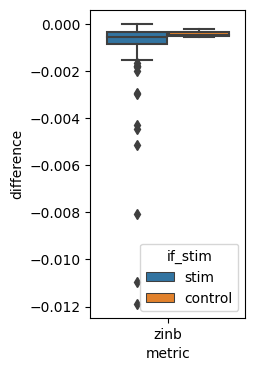

In [9]:
import pandas as pd
import seaborn as sns

print(differece0)

df=pd.DataFrame({'difference':differece0, 'if_stim':if_stim0, 'metric':metric0})
plt.figure(figsize=(2, 4))

box_plot=sns.boxplot(data=df,x="metric", y="difference", hue="if_stim")
plt.savefig('box-output.png')
# strip_plot=sns.stripplot(data=df,x="metric", y="difference",c='r', hue="if_stim")
# plt.savefig('strip-output.png')
# violin_plot=sns.violinplot(data=df,x="metric", y="difference", hue="if_stim")
# plt.savefig('violin-output1.png')


     difference  if_stim metric
0     -0.000146     stim   zinb
1     -0.000969     stim   zinb
2     -0.000867     stim   zinb
3     -0.000359     stim   zinb
4     -0.000161     stim   zinb
..          ...      ...    ...
96     0.000000     stim   zinb
97     0.000000     stim   zinb
98    -0.000544  control   zinb
99    -0.000466  control   zinb
100   -0.000224  control   zinb

[101 rows x 3 columns]


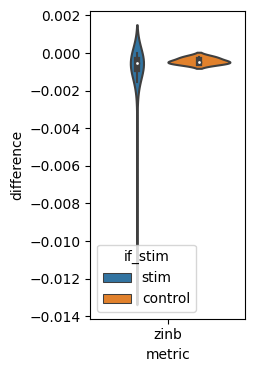

In [10]:
import pandas as pd
import seaborn as sns
df=pd.DataFrame({'difference':differece0, 'if_stim':if_stim0, 'metric':metric0})
plt.figure(figsize=(2, 4))
print(df)
# box_plot=sns.boxplot(data=df,x="metric", y="difference", hue="if_stim")
# plt.savefig('box-output.png')
# strip_plot=sns.stripplot(data=df,x="metric", y="difference",c='r', hue="if_stim")
# plt.savefig('strip-output.png')
violin_plot=sns.violinplot(data=df,x="metric", y="difference", hue="if_stim")
plt.savefig('violin-output2.png')


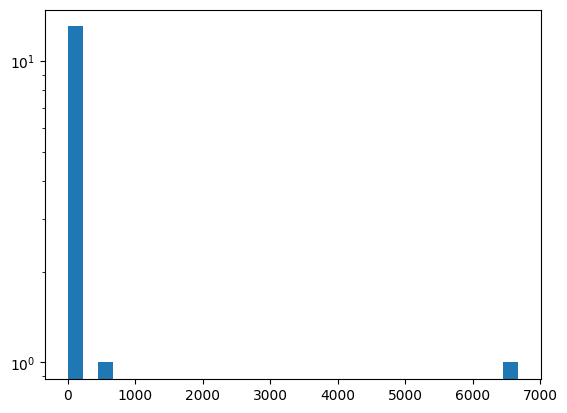

Optimization terminated successfully.
         Current function value: 4.684719
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                                 y   No. Observations:                   15
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       14
Method:                                      MLE   Df Model:                            0
Date:                           Mon, 08 May 2023   Pseudo R-squ.:              -3.131e-08
Time:                                   19:21:49   Log-Likelihood:                -70.271
converged:                                  True   LL-Null:                       -70.271
Covariance Type:                       nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [8]:
endog=[6679,469,151,0,27,12,5,5,3,6,2,0,1,0,1]
exog=np.ones_like(endog)

endog=np.array(endog)
exog=np.array(exog)



plt.hist(endog,bins=30)
plt.yscale('log')
plt.show()

#method 1 
#model_nb = NegativeBinomial(endog, exog, loglike_method='nb2')
#model_nb = NegativeBinomialP(endog, exog, p=2)
#res_nb = model_nb.fit(method='bfgs', maxiter=5000, maxfun=5000)

#method 2 
model_zinb = ZeroInflatedNegativeBinomialP(endog, exog)
res_nb = model_zinb.fit()
print(res_nb.summary())
print(res_nb.params)